In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import curve_fit
from matplotlib.colors import LogNorm
import fun.my_functions as mf
from molmass import Formula


# Load data

In [2]:
data = np.load("../data/jica_datarequest_nr8.npz")
n_data = np.load("../data/jica_datarequest_nr11.npz")
vel_data = np.load("../data/jica_datarequest_nr7.npz")
sc_pot_data = np.load("../data/jica_datarequest_nr10.npz")

In [3]:
spec_p = data['p1'].flatten()
spec_n = n_data['n1'].flatten()
time_p = data['time']
velocity = vel_data['speed'] * 1e3
sc_pot = sc_pot_data['scpot']

# Remove background

1
1


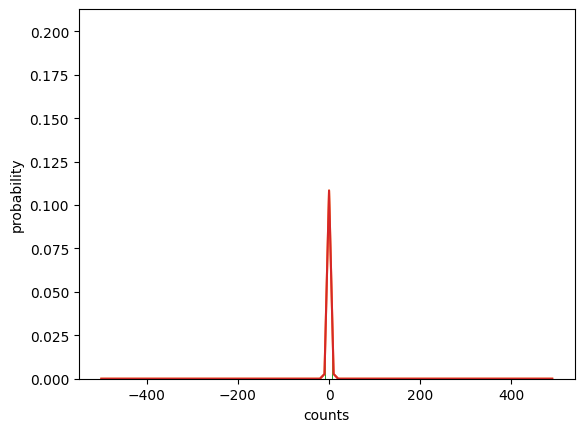

In [4]:
spec_p_c = mf.red_j_spec_err(spec_p, [400, 512], [0, 1])
e_bins_p = mf.energy_calibration('p')[:-1] # because loosing one bin in error correction
density_p = mf.calc_current(spec_p_c, 'p1')

In [5]:
MOL_p = 'PC2H5+'
MOI_p = Formula(MOL_p).mass
EOI_p = mf.calc_energy(MOI_p, sc_pot, velocity, instrument='p')

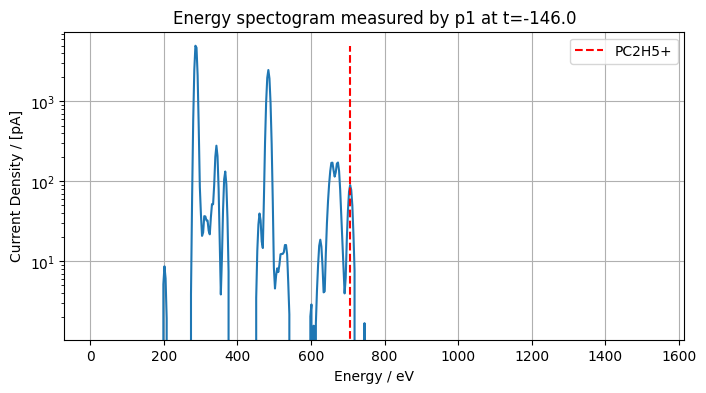

In [6]:
fig, ax = plt.subplots(figsize=(8, 4))  # width=8 inches, height=4 inches

ax.plot(e_bins_p, density_p)
ax.vlines(EOI_p, ymin=0, ymax=np.max(density_p), label=MOL_p, colors='r', linestyles='--')
# Add labels and title
ax.set_xlabel('Energy / eV')
ax.set_ylabel('Current Density / [pA]')
ax.set_title(f'Energy spectogram measured by p1 at t={time_p[0]}')
ax.legend()
ax.set_yscale('log')
# Optional: grid
ax.grid(True)

# Show the figure
plt.show()

1
1


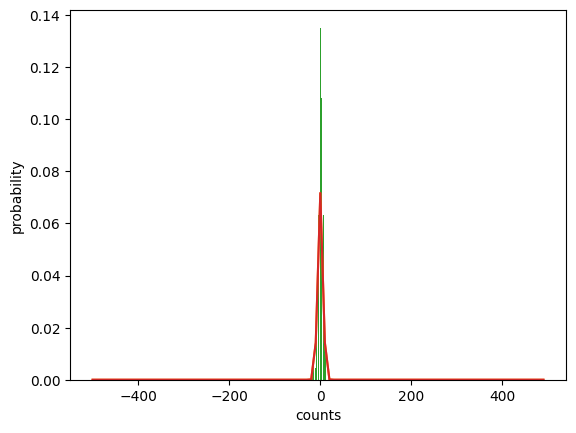

In [7]:
spec_n_c = mf.red_j_spec_err(spec_n, [400, 512], [0, 1], savename='n1')
e_bins_n = mf.energy_calibration('n')[:-1]
density_n = mf.calc_current(spec_n_c, 'n1')

In [8]:
MOL_n = 'CH3Br-'
MOI_n = Formula(MOL_n).mass
EOI_n = mf.calc_energy(MOI_n, sc_pot, velocity, instrument='n')

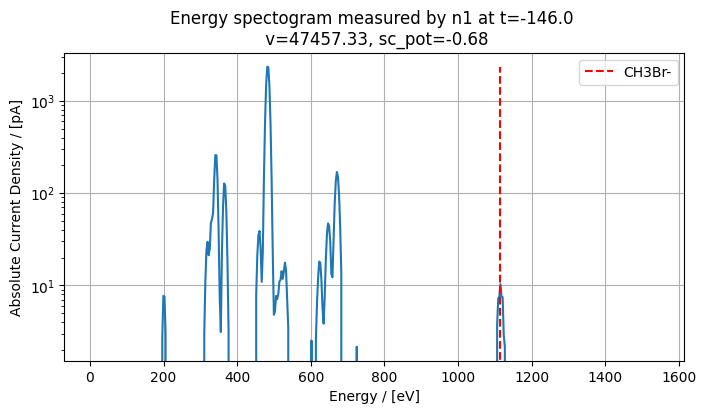

In [9]:
fig, ax = plt.subplots(figsize=(8, 4))  # width=8 inches, height=4 inches

ax.plot(e_bins_n, -density_n)
ax.vlines(EOI_n, ymin=0, ymax=np.max(-density_n), label=MOL_n, colors='r', linestyles='--')
# Add labels and title
ax.set_xlabel('Energy / [eV]')
ax.set_ylabel('Absolute Current Density / [pA]')
ax.set_title(f'Energy spectogram measured by n1 at t={time_p[0]} \n v={velocity[0]:.2f}, sc_pot={sc_pot[0]:.2f}')
ax.legend()
ax.set_yscale('log')
# Optional: grid
ax.grid(True)

# Show the figure
plt.show()

# extract ROI and fit
We will fit a gaussian with fixed mean, because we know the true mean: 
$$g(x)=A\exp \left(-{\frac {1}{2}}{\frac {(x-\mu )^{2}}{\sigma ^{2}}}\right)$$

In [10]:
# define the fit functions
def gauss_fixed_mean_p(x, A, std):
    mean = EOI_p
    return A * np.exp(- (x - mean) ** 2 / 2 / std / std)
def gauss_fixed_mean_n(x, A, std):
    mean = EOI_n
    return A * np.exp(- (x - mean) ** 2 / 2 / std / std)

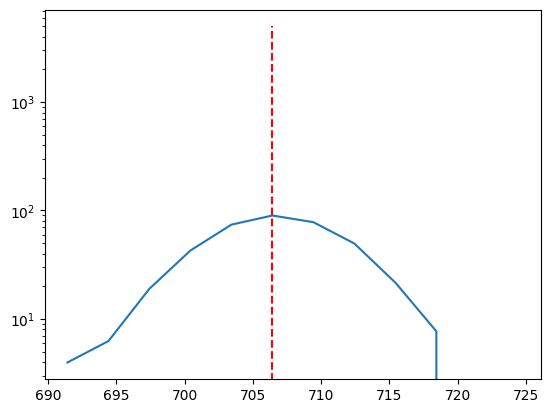

In [11]:
# first for positive: 
e_roi_p = e_bins_p[228:240]
dens_roi_p = density_p[228:240]
start = 228
stop = 240
plt.plot(e_bins_p[start:stop], density_p[start:stop])
plt.vlines(EOI_p, ymin=0, ymax=np.max(density_p), label=MOL_p, colors='r', linestyles='--')
plt.yscale('log')

std dev for p1 marker is: 5.235159764038491
area under positive marker is: 1176.1113956765366


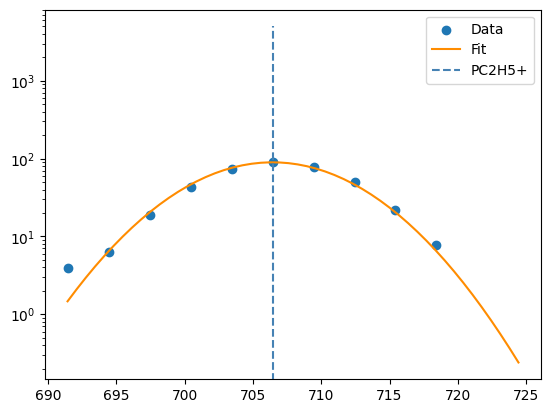

In [12]:
# do fit
popt, pcov = curve_fit(gauss_fixed_mean_p, e_roi_p, dens_roi_p)
A_p, std_p = popt
print('std dev for p1 marker is:', std_p)
plt.scatter(e_roi_p, dens_roi_p, label='Data')
plt.plot(np.linspace(e_roi_p.min(), e_roi_p.max()), gauss_fixed_mean_p(np.linspace(e_roi_p.min(), e_roi_p.max()), A_p, std_p), 'darkorange', label="Fit")
plt.vlines(EOI_p, ymin=0, ymax=np.max(density_p), label=MOL_p, colors='steelblue', linestyles='--')
plt.legend()
plt.yscale('log')

# do integration
# integral of gaussian is: A * std * 2pi**0.5
p_part = A_p * std_p * np.sqrt(2 * np.pi)
print('area under positive marker is:', p_part)

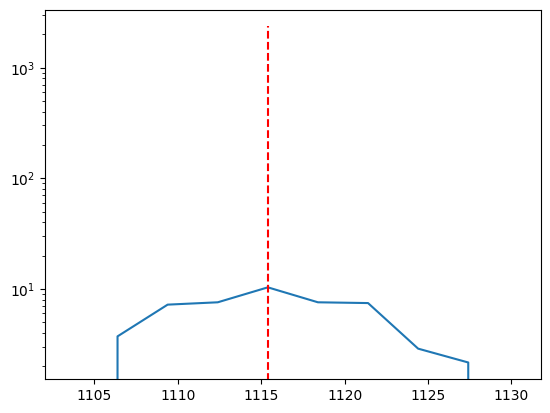

In [13]:
e_roi_n = e_bins_n[365:375]
dens_roi_n = density_n[365:375]
start = 365
stop = 375
plt.plot(e_bins_n[start:stop], -density_n[start:stop])
plt.vlines(EOI_n, ymin=0, ymax=np.max(-density_n), label=MOL_n, colors='r', linestyles='--')
plt.yscale('log')

std dev for p1 marker is: 6.280473732748107
area under negative marker is: 152.11171555346013


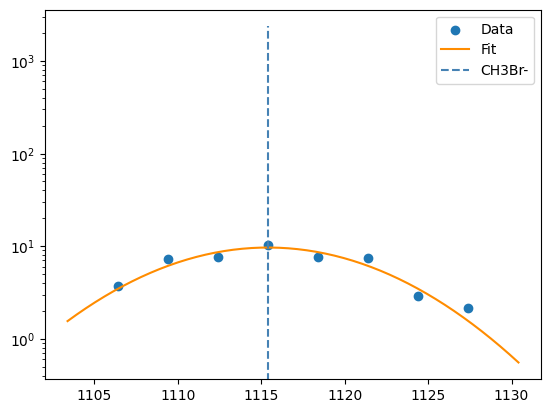

In [14]:
# do fit
popt, pcov = curve_fit(gauss_fixed_mean_n, e_roi_n, -dens_roi_n)
A_n, std_n = popt
print('std dev for p1 marker is:', std_n)
plt.scatter(e_roi_n, -dens_roi_n, label='Data')
plt.plot(np.linspace(e_roi_n.min(), e_roi_n.max()), gauss_fixed_mean_n(np.linspace(e_roi_n.min(), e_roi_n.max()), A_n, std_n), 'darkorange', label="Fit")
plt.vlines(EOI_n, ymin=0, ymax=np.max(-density_n), label=MOL_n, colors='steelblue', linestyles='--')
plt.legend()
plt.yscale('log')

# do integration
# integral of gaussian is: A * std * 2pi**0.5
n_part = A_n * std_n * np.sqrt(2 * np.pi)
print('area under negative marker is:', n_part)

calculate uncertainty on integration using gaussian error propagation!

# Calculate ratio between the two markers
expected: density ratio (CH3Br-/PC2H5+) equal to 1/2

In [15]:
ratio = n_part / p_part
print(ratio)

0.12933444579538372
